In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftshift, fft2, ifft2, ifftshift, fftfreq
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import matplotlib
from scripts.custom_functions import *
from tqdm import tqdm

matplotlib.rcParams['font.size'] = 22
matplotlib.rc('font',**{'family':'fantasy','fantasy':['xkcd']})
matplotlib.rc('text', usetex=True)

colors = ['#00ffff', '#008000', '#ffa500', 'magenta', 'b', '#ce2929', '#19c4b2', '#9341a6' ]

Setting the units, parameters of the pulsar and predictions.

In [5]:
# Units
pc=3.086e18 # in cm
c=2.99792458e10 # in cm/s
AU = 1.469e13 # in cm
re =2.8e-13 # in cm
mas_per_rad = 2.06265e8
one_mas_in_rad = 4.848e-9

# Pulsar's parameters and errors
dp, err_dp = 620.*pc, 60./620               # Siqi's
dlens=389.*pc                               # Siqi's, no error so considered constant

Deff = dp*dlens/(dp-dlens)
s = 1.-dlens/dp                             # dimensionless
err_Deff, err_s = err_dp, err_dp            # Same fractionnal errors as dp
Veff, err_Veff = 305*100000, 3./305         # Brisken's, in cm/s

# Observing parameters, considered exact
freqs = [314.5e6, 322.5e6, 330.5e6, 338.5e6]
ls = [c/f for f in freqs]
freq_obs = freqs[0]
l = c / freq_obs

# Assumptions for predictions, considered exact
T = 0.5*AU     
thetaT=T/dlens
dne = -(0.003*1.1 - 0.003)

dns = [-wvl**2./(2.*np.pi)*dne*re for wvl in ls] 
dn = -l**2./(2.*np.pi)*dne*re 
dn

1.2147852890204997e-13

All errors manipulated are fractionnal and dimensionless, the error analysis is still under development and need reviewing. It is documented in LaTex below for better reading.

analytical propagation : $\Delta\theta_{ref},\quad p_\ell=\Delta n\theta_T\sqrt{\theta_R},\quad \theta,\quad \beta,\quad R\quad \&\quad \theta_R$ 

bootstap : predicted $\Delta\theta$ and $\mu/\mu_0$

In [6]:
class Fold(object):
    def __init__(self, name, dtheta, mu):
        '''
        params :
            name (string) : for printing purposes
            dtheta, mu : 2-elements array or list, 
              error is the second value of the theta and mu lists,
              in the same dimensions, if no error set to 0
        return :
            self.err_mu : fractionnal error on mu
            self.err_dtheta : fractionnal error on dtheta
        '''
        self.name = name
        self.dtheta = dtheta[0]
        self.mu = mu[0]
        self.err_mu = mu[1]/mu[0]
        self.err_dtheta = dtheta[1]/dtheta[0]
    
    def __repr__(self):
        '''print function for output of a print(Fold object) command, customizable'''
        return 'Fold object {0}'.format(self.name)
    
    def get_dtheta_ref(self, show=False):
        ''' if show=True, will see dtheta-mu points with theoretical curve
        return :
            self.dtheta_ref [rad]
            self.err_dtheta_ref fractionnal, dimensionless'''
        theta_theo = ((3./2.)*self.mu)**(-3./5.)
        self.dtheta_ref = ((self.dtheta/mas_per_rad)/theta_theo)
        
        err_theta_theo = self.err_mu*(3./5.)
        self.err_dtheta_ref = np.sqrt( (err_theta_theo)**2 + (self.err_dtheta)**2 )

        if show:
            thetas = np.arange(0.1, 1000, 0.1)
            mus =  (2./3.)*np.abs(thetas)**(-5./3.)
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot(1,1,1)
            theory = ax.plot(thetas, mus, 'b-')
            plt.ylabel(r'$|\mu / \mu_0|$')
            plt.xlabel(r'$|\Delta\theta| [mas] $')
            plt.plot(self.dtheta, self.mu, 'mo', label=r'original $\Delta \theta$ position')
            plt.plot(self.dtheta/(self.dtheta_ref*mas_per_rad), self.mu, 'co', label=r'corrected $\Delta \theta/\Delta \theta_{ref}$  position')
            ax.set_yscale('log')
            ax.set_xscale('log')
            plt.legend()
            plt.show()
    
    def get_params(self):
        '''
        with self.dtheta_ref, return :
            self.lens_param (dn*thetaT*sqrt(thetaR)) dimensionless
            self.theta [mas]: observed position of pulsar relative to apex of fold
            self.beta [mas]: real position of pulsar
            self.thetaR dimensionless
            self.R [cm, or same dimension as dlens] 
        
        and errors on these, see below for justifications
        '''
        self.lens_param = 2*((self.dtheta_ref)**(5./2.))/(np.sqrt(2)*s) 
        self.theta = (((-np.sqrt(2)*s*self.lens_param/(2*self.dtheta/mas_per_rad))**(2.))**(1./3.))*mas_per_rad
        self.beta = self.theta - self.dtheta
        self.thetaR = (self.lens_param/(thetaT*dn))**2
        self.R = self.thetaR*dlens # in cm 
        
        self.err_lens_param = np.sqrt(((5./2.)*self.err_dtheta_ref)**2 + (err_s)**2)
        self.err_theta = (2./3)*np.sqrt((err_s)**2 + (self.err_dtheta)**2 + (self.err_lens_param)**2)
        self.err_beta = np.sqrt(self.err_theta**2 + self.err_dtheta**2)
        self.err_R = self.err_lens_param*2
         
    def make_predictions(self, center_freqs):
        '''
        params : 
            center_freqs : list of central frequencies of observations
        return :
            self.predicted_thetas, mus from solution of lens equation from Dana's functions
            self.predicted_dthetas, using theta - self.beta
            self.predicted_dthetas2, same but using another equivalent path
        '''
        self.predicted_thetas = []
        self.predicted_mus = []
        
        for f in center_freqs:
            l = c / f
            dn = -l**2./(2.*np.pi)*dne*re
            self.predicted_thetas.append(get_theta(dn, self.thetaR, thetaT, self.beta/mas_per_rad, s)[0]*mas_per_rad)
            self.predicted_mus.append(get_mu(dn, self.thetaR, thetaT, self.beta/mas_per_rad, s)[0])
            
        self.predicted_dthetas = [(theta - self.beta) for theta in self.predicted_thetas]
        self.predicted_dthetas2 = [(np.sqrt(2)*s*self.lens_param*(dns[i]/dns[0]))/(2*(self.predicted_thetas[i]/mas_per_rad)**(3./2.))*mas_per_rad for i in range(4)]

    def bootstrap_predictions(self, center_freqs, N):
        '''
        Under development, 
            produces Gaussian distributions for thetaR, beta and s
              (could be restricted more using truncated normal distribution function's limits, expressed in nb of sigma)
            makes sure that these don't cross the origin
            for each 3-uple left and frequency band, computes a prediction on dtheta and mu
        
        params:
            center_freqs for which we want to make predictions
            N initital size of distribution, will be reduced by limits on parameters
        return : 
            self.bootstrapped_thetas, mus : list of 4 distributions, one per frequency band
            self.thetaRs, betas, ses : distributions of bootstrapped parameters
        '''
        thetaRs = stats.truncnorm.rvs(6, -6, loc=self.thetaR, scale=self.err_R*self.thetaR, size=N)
        betas = stats.truncnorm.rvs(6, -6, loc=self.beta, scale=self.err_beta*abs(self.beta), size=N)
        ses = stats.truncnorm.rvs(6, -6, loc=s, scale=err_s*s, size=N)
        indices_to_clear = []
        for i in range(N):
            if thetaRs[i] <= 0.01:
                indices_to_clear.append(i)
            if betas[i] >= -2.:
                indices_to_clear.append(i)
            if ses[i] <= 0:
                indices_to_clear.append(i)
        indices_to_clear2 = np.unique(np.array(indices_to_clear, dtype=int))
        thetaRs = np.delete(thetaRs, indices_to_clear2)
        betas = np.delete(betas, indices_to_clear2)
        ses = np.delete(ses, indices_to_clear2)
        
        self.bootstrapped_thetas = []
        self.bootstrapped_mus = []
  
        for ii in range(len(center_freqs)):
            f = center_freqs[ii]
            l = c/ f
            dn = -l**2./(2.*np.pi)*dne*re            
            self.bootstrapped_thetas.append(np.zeros(thetaRs.shape))
            self.bootstrapped_mus.append(np.zeros(thetaRs.shape))
            for i in tqdm(range(len(ses))):
                self.bootstrapped_thetas[ii][i] = get_theta(dn, thetaRs[i], thetaT, betas[i]/mas_per_rad, ses[i])[0]*mas_per_rad
                self.bootstrapped_mus[ii][i] = get_mu(dn, thetaRs[i], thetaT, betas[i]/mas_per_rad, ses[i])[0]
        
        self.errs_predicted_dthetas = [np.std(self.bootstrapped_thetas[i]) for i in range(len(center_freqs))]
        self.errs_predicted_mus = [np.std(self.bootstrapped_mus[i]) for i in range(len(center_freqs))]
        self.err_predicted_dthetas = [np.sqrt(self.err_beta**2 + (self.errs_predicted_dthetas[i])**2) for i in range(len(center_freqs))]
        self.thetaRs = thetaRs
        self.betas = betas
        self.ses = ses
        

Here is a readable explanation of error propagation into the Fold object, for simplicity, we note $\frac{\mu}{\mu_0}$ as $\mu$. All the analytical propagation have the actual calculation on the left and the error on the right. The rules used are that constant don't affect the error, a power multiplies the fractional error and products of powers use the general formula for $z= cx^Ny^M$,

$$\sigma_z = \sqrt{N^2\left(\sigma_x\right)^2 + M^2\left(\sigma_y\right)^2}.$$

\__ __init__ __  : the errors on $\mu$ and $\Delta\theta$ are transformed into fractional errors

__get_dtheta_ref__ : the notation here is $\frac{\Delta\theta_{ref}}{\Delta\theta} = \frac{1}{\Delta\theta_{theo}}$, therefore, we first compute
$$\Delta\theta_{theo} = \left(\frac{3}{2} \mu \right)^{-3/5}\qquad \sigma_{\Delta\theta_{theo}} = (3/5)\sigma_{\mu}$$
to then get 
$$\Delta\theta_{ref} = \frac{\Delta\theta}{\Delta\theta_{theo}}\qquad \sigma_{\Delta\theta_{ref}} = \sqrt{\sigma_{\Delta\theta}^2 + \sigma_{\Delta\theta_{theo}}^2}$$


__get_params__ : 

$$p_\ell = \frac{2(\Delta\theta_{ref})^{5/2}}{\sqrt{2}s} \qquad \sigma_{p_\ell} = \sqrt{(\frac{5}{2}\sigma_{\Delta\theta})^2 + \sigma_{s}^2}$$
        
$$\theta = \left(\frac{-\sqrt{2} s p_\ell}{2\Delta\theta}\right)^{2/3} \qquad \sigma_\theta = \frac{2}{3}\sqrt{\sigma_s^2 + \sigma_{\Delta\theta}^2 + \sigma_{p_\ell}^2}$$

$$\beta = \theta-\Delta\theta  \qquad \sigma_\beta= \sqrt{\sigma_\theta^2 + \sigma_{\Delta\theta}^2}$$
$$\theta_R = \left(\frac{p_\ell}{\theta_T\Delta n}\right)^2 \qquad \sigma_{\theta_R} =\sigma_R= 2 \sigma_{p_\ell}$$

__bootstrap_predictions__ :




## Testing bootstapping errors

In [50]:
test = Fold('test', [16.2774788, 1.5], [0.0010368129, 0.0003])
test.get_dtheta_ref(show=False)
test.get_params()
test.make_predictions(freqs)

In [51]:
test.bootstrap_predictions(freqs, 10000)

100%|██████████| 8265/8265 [00:04<00:00, 1980.65it/s]


In [59]:
print('resulting N : '+ str(len(test.betas)))

resulting N : 8265


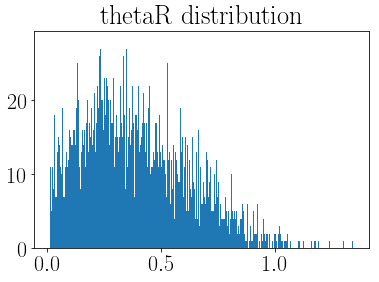

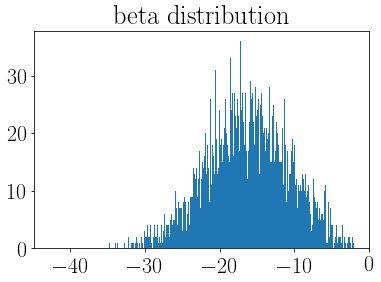

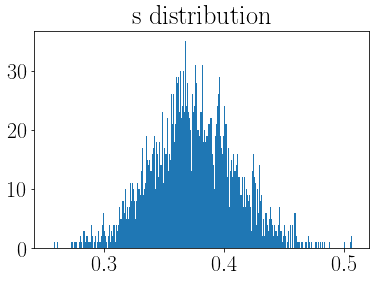

In [60]:
plt.hist(test.thetaRs, bins=1000)
plt.title('thetaR distribution')
plt.show()
plt.hist(test.betas, bins=1000)
plt.title('beta distribution')
plt.show()
plt.hist(test.ses, bins=1000)
plt.title('s distribution')
plt.show()

fractionnal errors on dtheta : [0.35783190383201197, 0.35781922882906286, 0.35780764256102199, 0.35779702881455266]
estimate error bars on dtheta : 5.82460122859


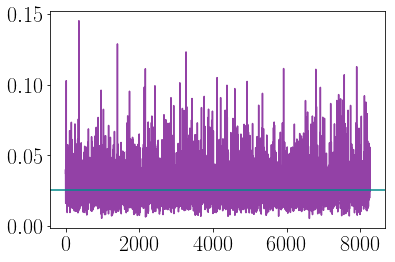

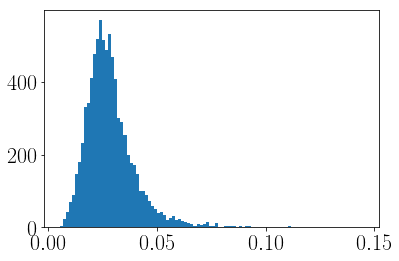

 predicted : 0.0253150499921
 mean of bootstrap : 0.0286968297418
 std of bootstrap : 0.0119009112222


In [62]:
i=0

print('fractionnal errors on dtheta : {0}'.format(test.err_predicted_dthetas))
print('estimate error bars on dtheta : {0}'.format(test.predicted_dthetas[0]*test.err_predicted_dthetas[0]))

plt.plot(test.bootstrapped_thetas[i], c =colors[7])
plt.axhline(test.predicted_thetas[i], c='darkcyan')
plt.show()
plt.hist(test.bootstrapped_thetas[i], bins=100, )
plt.show()
print(' predicted : {0}\n mean of bootstrap : {1}\n std of bootstrap : {2}'.format(test.predicted_thetas[i], np.mean(test.bootstrapped_thetas[i]), np.std(test.bootstrapped_thetas[i])))

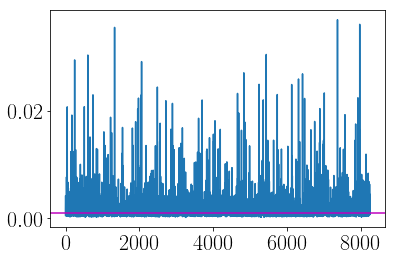

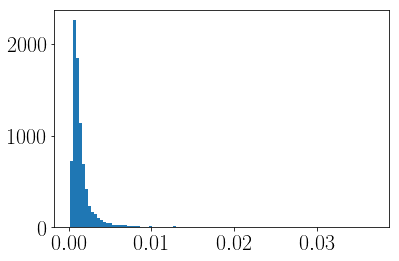

 predicted : 0.00103573903185
 mean of bootstrap : 0.00165101522472
 std of bootstrap : 0.00228883244508


In [48]:
plt.plot(test.bootstrapped_mus[i])
plt.axhline(test.predicted_mus[i], c='m')
plt.show()
plt.hist(test.bootstrapped_mus[i], bins=100, )
plt.show()
print(' predicted : {0}\n mean of bootstrap : {1}\n std of bootstrap : {2}'.format(test.predicted_mus[i], np.mean(test.bootstrapped_mus[i]), np.std(test.bootstrapped_mus[i])))

## Predictions with arclets bright in freq 00

In [7]:
arclets = np.loadtxt('/mnt/scratch-lustre/bdesy/b0834/data/results/ratio_main_masks_method/arclet00_ID_dthetas_mus3001_vf.txt')

array([[  0.00000000e+00,   1.62775000e+01,   0.00000000e+00,
          1.11499714e-03,   0.00000000e+00],
       [  1.00000000e+00,   1.85079000e+01,   0.00000000e+00,
          2.05843433e-03,   0.00000000e+00],
       [  2.00000000e+00,   1.90237000e+01,   0.00000000e+00,
          1.38508566e-03,   0.00000000e+00],
       [  3.00000000e+00,   1.91462000e+01,   0.00000000e+00,
          1.04314493e-03,   0.00000000e+00],
       [  4.00000000e+00,   2.03450000e+01,   0.00000000e+00,
          1.13914473e-03,   0.00000000e+00],
       [  5.00000000e+00,   2.20030000e+01,   0.00000000e+00,
          1.25168843e-03,   0.00000000e+00],
       [  6.00000000e+00,   2.26010000e+01,   0.00000000e+00,
          1.24448022e-03,   0.00000000e+00],
       [  7.00000000e+00,   2.47330000e+01,   0.00000000e+00,
          7.35090703e-04,   0.00000000e+00]])

In [8]:
folds = [Fold(str(arclets[i][0]), dtheta=[arclets[i][1], arclets[i][2]], mu=[arclets[i][3], arclets[i][4]]) for i in range(len(arclets))]

In [9]:
print('dtheta         theta        beta        R [pc]     more or less')
for f in folds:
    f.get_dtheta_ref(show=False)
    f.get_params()
    f.make_predictions(freqs)
    print('{0:.6}       {1:.4}     {2:.6}    {3:.7}     {4:.7}  '.format(f.dtheta, f.theta, f.beta, f.R/pc, f.err_R*(f.R/pc)))

dtheta         theta        beta        R [pc]     more or less
16.2775       0.02722     -16.2503    145.2624     28.11531  
18.5079       0.05715     -18.4508    1736.962     336.1861  
19.0237       0.03952     -18.9842    607.1532     117.5135  
19.1462       0.02996     -19.1162    267.8184     51.83582  
20.345       0.03476     -20.3102    472.5183     91.45516  
22.003       0.04131     -21.9617    927.4525     179.5069  
22.601       0.04219     -22.5588    1042.307     201.7369  
24.733       0.02727     -24.7057    337.1322     65.2514  


scripts/custom_functions.py:192: RuntimeWarning: invalid value encountered in power
  + ( s * dn * thetaR * thetaT)/(theta**3.*(1. + thetaR/(2. * theta))**(1./2.))))
scripts/custom_functions.py:192: RuntimeWarning: invalid value encountered in sqrt
  + ( s * dn * thetaR * thetaT)/(theta**3.*(1. + thetaR/(2. * theta))**(1./2.))))


Now that we have objects to work on, it greatly lessens the chances to mess around with lists and whatnot. 

To predict $\mu$ and $\theta$, we need $\Delta n,\ \theta_T$ and $s$, from the general system and $\theta_R,\ \beta$ from the particular folds, all of which seems to have been gathered.

We also need to make sure all the angles inputed in the function are dimensionless, a.k.a in radiansbut this has been taken care of in the Fold's prediction function.

In [15]:
print('predictions on theta for each band\n\n id     theta       00        01        02       03')
for f in folds: 
    print('{0}    {1:0.5f}   {2:0.5f}   {3:0.5f}   {4:0.5f}   {5:0.5f}  '.format(f.name, f.theta, f.predicted_thetas[0], f.predicted_thetas[1], f.predicted_thetas[2], f.predicted_thetas[3]))

predictions on theta for each band

 id     theta       00        01        02       03
0.0    0.02722   0.02722   0.02633   0.02548   0.02468  
1.0    0.05715   0.05715   0.05527   0.05349   0.05182  
2.0    0.03952   0.03952   0.03822   0.03700   0.03584  
3.0    0.02996   0.02996   0.02897   0.02804   0.02716  
4.0    0.03476   0.03476   0.03362   0.03254   0.03152  
5.0    0.04131   0.04131   0.03995   0.03867   0.03746  
6.0    0.04219   0.04219   0.04080   0.03949   0.03825  
7.0    0.02727   0.02727   0.02637   0.02553   0.02473  


To make measurements on the predictions, I need to retransform the $\theta$ in $\Delta\theta$

In [16]:
print('predictions on dtheta for each band\n\n id     dtheta       00        01        02       03')
for f in folds: 
    print('{0}    {1:0.5f}   {2:0.5f}   {3:0.5f}   {4:0.5f}   {5:0.5f}  '.format(f.name, f.dtheta, f.predicted_dthetas[0], f.predicted_dthetas[1], f.predicted_dthetas[2], f.predicted_dthetas[3]))

predictions on dtheta for each band

 id     dtheta       00        01        02       03
0.0    16.27750   16.27750   16.27660   16.27576   16.27496  
1.0    18.50790   18.50790   18.50602   18.50425   18.50257  
2.0    19.02370   19.02370   19.02240   19.02117   19.02001  
3.0    19.14620   19.14620   19.14521   19.14428   19.14340  
4.0    20.34500   20.34500   20.34386   20.34278   20.34176  
5.0    22.00300   22.00300   22.00164   22.00036   21.99915  
6.0    22.60100   22.60100   22.59961   22.59830   22.59706  
7.0    24.73300   24.73300   24.73210   24.73126   24.73045  


In [22]:
print('predictions on mu for each band\n\n id     mu       00        01        02       03')
for f in folds: 
    print('{0}    {1:0.6f}   {2:0.6f}   {3:0.6f}   {4:0.6f}   {5:0.6f}  '.format(f.name, f.mu, f.predicted_mus[0], f.predicted_mus[1], f.predicted_mus[2], f.predicted_mus[3]))

predictions on mu for each band

 id     mu       00        01        02       03
0.0    0.001064   0.001063   0.001028   0.000995   0.000964  
1.0    0.001964   0.001960   0.001896   0.001836   0.001778  
2.0    0.001322   0.001320   0.001277   0.001236   0.001197  
3.0    0.000995   0.000994   0.000962   0.000931   0.000902  
4.0    0.001087   0.001086   0.001050   0.001017   0.000985  
5.0    0.001194   0.001193   0.001154   0.001117   0.001082  
6.0    0.001187   0.001186   0.001147   0.001110   0.001076  
7.0    0.000701   0.000701   0.000678   0.000656   0.000636  


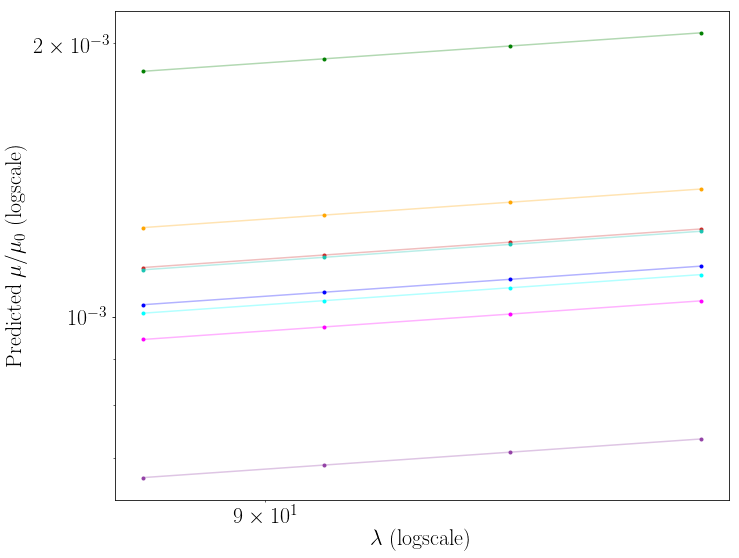

([1.3283853522031879,
  1.3242117494902257,
  1.3271893072838306,
  1.3287037039410894,
  1.3282783787995427,
  1.3277799138853086,
  1.3278118345477821,
  1.3300693691508667],
 1.3333333333333333)

In [20]:
lambdas = np.array([c/f for f in freqs])
lambdas**(4./3)
fig = plt.figure(figsize=(11,9))
for i in range(8):
    plt.loglog(lambdas, folds[i].predicted_mus, 'o', c=colors[i], ms=3, basex=10, basey=10)
    plt.loglog(lambdas, folds[i].predicted_mus, '-', c=colors[i], ms=2, alpha=0.3, basex=10, basey=10)
plt.ylabel('Predicted $\mu/\mu_0$ (logscale)')
plt.xlabel('$\lambda$ (logscale)')
plt.show()

slopes=[]
for i in range(8):
    y1 = np.log10(folds[i].predicted_mus[0])
    y2 = np.log10(folds[i].predicted_mus[3])
    x1 = np.log10(lambdas[0])
    x2 = np.log10(lambdas[3])
    m=(y2-y1)/(x2-x1)
    slopes.append(m)
slopes, 4./3

In [21]:
print('verification of the limit on theta\n\n id     theta    thetaR     orders magn.')
for f in folds: 
    order = f.thetaR / (f.theta)
    print('{0}    {1:0.5f}    {2:0.5f}      {3:0.5f} '.format(f.name, f.theta, f.thetaR, order))

verification of the limit on theta

 id     theta    thetaR     orders magn.
0.0    0.02722    0.37343      13.71674 
1.0    0.05715    4.46520      78.13673 
2.0    0.03952    1.56081      39.48988 
3.0    0.02996    0.68848      22.98118 
4.0    0.03476    1.21470      34.94147 
5.0    0.04131    2.38420      57.71287 
6.0    0.04219    2.67945      63.50958 
7.0    0.02727    0.86666      31.77911 


## Testing for main arclet to see if 10x is a good approximation

In [83]:
theta_ma = -15.87
dtheta_ma = 10.230637146806034
mu_ma = 0.0513892242725

In [84]:
mf = Fold('main arclet', dtheta=[dtheta_ma, 0.1*dtheta_ma], mu=[mu_ma, 0.2*mu_ma])

In [86]:
mf.get_dtheta_ref(show=False)
mf.get_params()
mf.get_curvature()
mf.make_predictions(freqs)

print('predictions on dtheta for each band\n\n id     dtheta       00        01        02       03')
for f in [mf]: 
    print('{0}    {1:0.5f}   {2:0.5f}   {3:0.5f}   {4:0.5f}   {5:0.5f}  '.format(f.name, f.dtheta, f.predicted_dthetas[0], f.predicted_dthetas[1], f.predicted_dthetas[2], f.predicted_dthetas[3]))
print('predictions on mu for each band\n\n id     mu       00        01        02       03')
for f in [mf]: 
    print('{0}    {1:0.6f}   {2:0.6f}   {3:0.6f}   {4:0.6f}   {5:0.6f}  '.format(f.name, f.mu, f.predicted_mus[0], f.predicted_mus[1], f.predicted_mus[2], f.predicted_mus[3]))

predictions on dtheta for each band

 id     dtheta       00        01        02       03
main arclet    10.23064   10.23064   10.20589   10.18247   10.16028  
predictions on mu for each band

 id     mu       00        01        02       03
main arclet    0.051389   0.048877   0.047526   0.046237   0.045007  


# Represent discrepancy between measurements and predictions

In [23]:
mac=True
if mac:
    mp = np.load('dtheta_position_arclets00_8rows.npy').reshape(8, -1)
else:
    mp = np.load('/mnt/scratch-lustre/bdesy/b0834/data/measurements/dtheta_position_arclets00_8rows.npy').reshape(8, -1)
measured_positions = []
for i in range(8):
    trus = []
    for ii in range(3):
        trus.append(mp[i][0][ii+1])
    measured_positions.append(trus)
measured_positions

[[16.2775, 16.262, nan],
 [18.507899999999999, 18.495000000000001, 18.462],
 [19.023700000000002, 19.010999999999999, 18.995000000000001],
 [19.1462, 19.138999999999999, 19.126000000000001],
 [20.344999999999999, 20.332999999999998, 20.324000000000002],
 [22.003, 21.989000000000001, 21.975999999999999],
 [22.600999999999999, 22.593, nan],
 [24.733000000000001, 24.725000000000001, 24.712]]

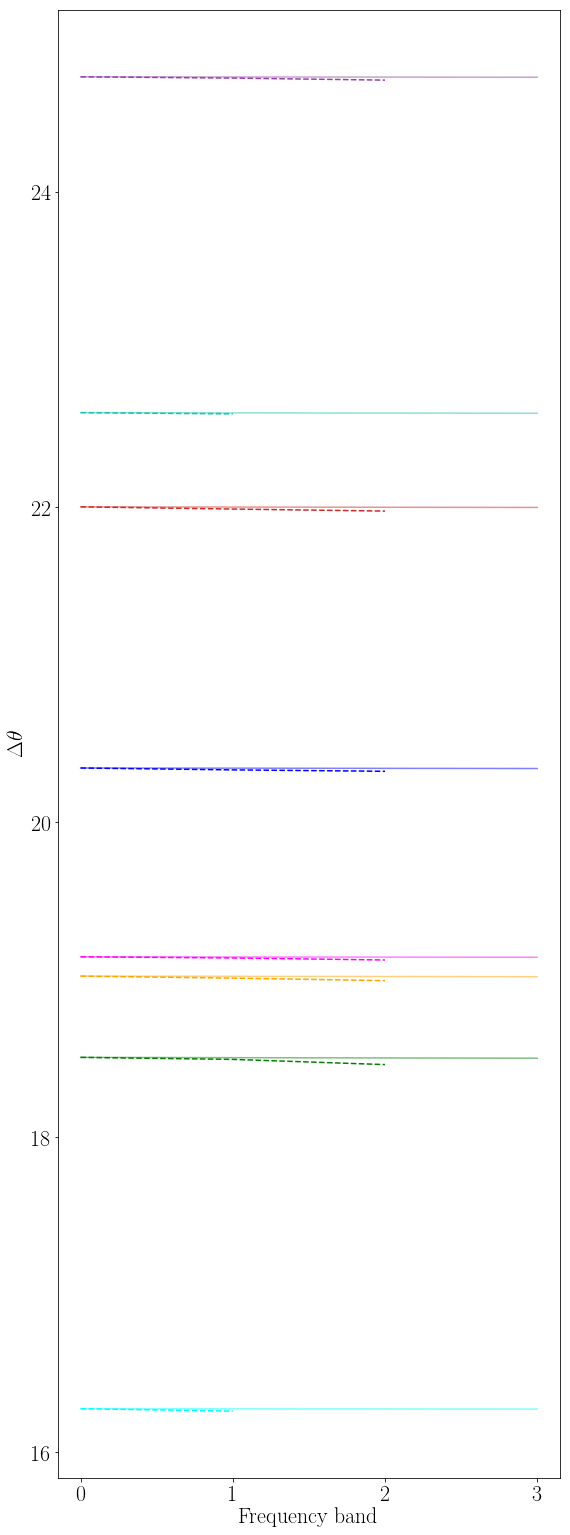

In [24]:
fig= plt.figure(figsize=(9,27))
xaxis=[0, 1, 2, 3]
for i in range(8):
    plt.plot(xaxis, folds[i].predicted_dthetas, c=colors[i], alpha=0.5)
    plt.plot(xaxis[:3], measured_positions[i], '--', c=colors[i], label='Faint arclet '+str(i))
#plt.ylim(18.2, 19.5)
plt.xticks(xaxis)
plt.xlabel('Frequency band')
plt.ylabel(r'$\Delta\theta$')
#plt.legend()
plt.show()